# Hledání nejlepšího nastavení hyperparametrů
V této práci budeme hledat nejlepší nastavení hyperparametrů heuristik *SG, FSA, GO a DE* na objektivní funkci *TSPGrid(3,3)* pomocí heuristiky *SG*. Jako spodní a horní mez si zvolíme nějakou množinu hyperparametrů zkoumané heuristiky a jako skóre budeme uvažovat hodnotu Feoktistova kritéria při běhu experimentu prvního řádu. V jednom experimentu prvního řádu pustíme nějaký větší počet běhu heuristiky, který se stihne spočítat za přesně daný čas na zkoumanou objektovou funkci *TSPGrid(3,3)*.

## Co jsem vylepšil?
- Nagenerování nové trasy pomocí metody 0 a metody 1 je ve funkci *generate_point()* viz. obrázek
<img src="img/method0.jpg">
<img src="img/method1.jpg">
Pro experimentální běhy Vybíráme původní náhodné generování trasy s názvem method2, protože obě nově naimplementované metody nám generují skoro optimální řešení a to by nám při běhu heristik značně ovlivnilo výsledky. Heuristiky by velmi rychle dosáhly f_star řešení.
- Metoda výběru sousední trasy ve funkci *get_neighbourhood()*
Původně byla naimplementována metoda *SWAP*, která prohodí dva prvky. Jelikož bylo pracováno se zakódovaným vektorem a pro implementaci daších metod jsem si potřeboval tento vektor odkódovat, tak jsem tuhle metodu rovnou přepsal tak, aby pracovala s nezakódovaným vektorem. Na konci pomocí napimplementované metody *encode()* tento nezakódovaný vektor zakóduju a vrátím pomocí return.
Dále jsem naimplementoval metody *REVERSE* a *MOVE*.
Na obrázku můžeme vidět, co se stane s nezakódovanou trasou při použití metod pro změnu trasy.
<img src="img/neighborhood.jpg">
Na začátku náhodně vygenerujeme číslo (1,2 nebo 3) a použitou metodu pro změnu trasy vybereme na základě vygenerovaného čísla.
- Funkci *encode()*, která jako vstup bere zakódovaný vektor a vrací nezakódovaný vektor.
- Opravil jsem generování gridu, který správně fungoval jen pro čtvercové mřížky.
- Výpis posledního řešení u heuristiky *FSA*.
- Pár dalších drobných úprav kódů tak, aby mi fungoval můj výpočet.



## Co jsem nově naimplementoval?

### soubor hyperparameters.py
- Jelikož jsem používal heuristiku *SG* na určení optimálních parametrů heuristik při dané objektivní funkci, tak tato heuristika musí mít svoji dolní a horní mez parametrů. Tyto meze, jména parametrů, zda je parametr diskrétní, nebo spojitý a příslušná heuristika jsou zde naimplementovány v datových strukturách dictionary.
### soubor objfun_tune_hyperparameters
- Objektivní funkce *TuneHyperparameters(ObjFun)*, která má za úkol najít optimální množinu hyperparametrů v dané mřížce, která je dána spodní a horní mezí.
- V závislosti na příslušné heuristice a tedy počtu a rozmezí jejich hyperparametrů generujeme nový vektor hyperparametrů pomocí funkce *generate_point()*.
- K danému bodu jsme schopni nagenerovat okolí bodů pomocí funkce *get_neighbourhood()*. Generování sousedního bodu je závislé, zda je element (parametr) na konkrétní pozici diskrétní nebo spojitý.
- Pro ohodnocení toho, jak je heuristika s danými hyperparametry dobrá slouží funkce *evalute()*. Tato funkce spustí experiment *first_order_experiment()* s danou heuristikou a příslušnými hyperparametry na pevně danou objektivní funkci *TSPGrid(3,3)*. Experiment prvního řádu běží pevně daný čas. Jako výsledek tohoto experimentu máme několik řádků (běhů) v němž jsou počet evaluací a délka trasy. Z těchto dat spočteme kritérium *feo*, které nám vrací funkce *evaluate()*. Sestrojili jsme tedy novou objektivní funkci, jejíž vstupní vektor je vektor hyperparametrů heuristiky pro který vrací kritérium *feo*.
### soubor stats.py
- Obsahuje základní statistiky pro heuristické výpočty, funkce na vyprintování, ukládání a načtení výsledků a funkci *second_order_experiment*, ve kterém používáme heuristiku *SG* s pevně danými parametry na naši sestrojenou objektivní funkci *TuneHyperparameters(ObjFun)*. Celý proces je znázorněn na následujícím obrázku.

# Diagram procesu
<img src="img/diag.jpg">

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import extrenal librarires
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
sns.set()

In [3]:
# Import our code
from objfun_tsp import TSPGrid
from objfun_tune_hyperparameters import TuneHyperparameters
from stats import create_table, second_order_experiment, create_files, read_data, pivot_table,\
delete_files, save_object, mean_and_variance

In [4]:
# setting up important parameters
first_order_of = TSPGrid(3, 3)
fstar_tolerance = 1 # we eval success in second order experiment only if we reach f* multiplied by this tolerance
first_order_exp_time = 10 # seconds
second_order_heur_maxeval = 10
second_order_exp_num_runs = 6
# Final time of whole second order experiment is given by multiplication of three above variables. Lets run 10 mins.
second_order_heur_hmax = 1 # second order SG hmax
second_order_heur_random_descent = True # second order SG random descent
# we are still satisfied, if we get sollution good enough
first_order_of.fstar = first_order_of.fstar*fstar_tolerance

### Hledání nejlepších hyperparametrů pro heuristiku Shoot and Go (výpočet trvá 10 minut)

In [138]:
# name of our first order heuristic
first_order_heur = "SG"
# create files of our results, if they do not exist already
create_files(first_order_heur) # append new data into files, if they already exists 

In [6]:
# If you run these experiments, results will be slightly different because of randomness

# we create second order objective function
second_order_of = TuneHyperparameters(first_order_heur, first_order_of, first_order_exp_time)
# run second order experiment
results_sg = second_order_experiment(second_order_of, first_order_heur,
                    second_order_exp_num_runs, second_order_heur_maxeval,
                    second_order_heur_hmax, second_order_heur_random_descent)
save_object(results_sg, globals())
print(results_sg)

==============Start of second order experiment==============
PARAMETERS OF SG: ['maxeval', 'hmax', 'random_descent']
======0-th run of second order experiment with 10 evals======
Parameters_of_SG: [179.0, 5.0, 0.0], feo: 199.49
Parameters_of_SG: [177.0, 5.0, 0.0], feo: 183.9
Parameters_of_SG: [181.0, 4.0, 1.0], feo: 386.26
Parameters_of_SG: [181.0, 3.0, 1.0], feo: 557.07
Parameters_of_SG: [443.0, 1.0, 1.0], feo: 3316.25
Parameters_of_SG: [443.0, 1.0, 0.0], feo: 1798.86
Parameters_of_SG: [710.0, 0.0, 1.0], feo: 1380.86
Parameters_of_SG: [707.0, 0.0, 1.0], feo: 1708.21
Parameters_of_SG: [307.0, 1.0, 1.0], feo: 1729.92
Parameters_of_SG: [307.0, 1.0, 0.0], feo: 1576.44
======1-th run of second order experiment with 10 evals======
Parameters_of_SG: [465.0, 0.0, 0.0], feo: 1220.58
Parameters_of_SG: [465.0, 0.0, 1.0], feo: 1128.11
Parameters_of_SG: [661.0, 1.0, 1.0], feo: 1553.47
Parameters_of_SG: [661.0, 0.0, 1.0], feo: 1253.75
Parameters_of_SG: [532.0, 2.0, 0.0], feo: 821.09
Parameters_of_S

Pro heursitiku *SG* jsme dostali nejlepší hodnotu feo kritéria (153.98) pro množinu hyperparametrů *(maxeval=218, hmax=10, random_descent=True)*. Z tabulky se zdá, že se zvyšujícím se počtem hmax se výrazně snižuju feo.

<IPython.core.display.Javascript object>


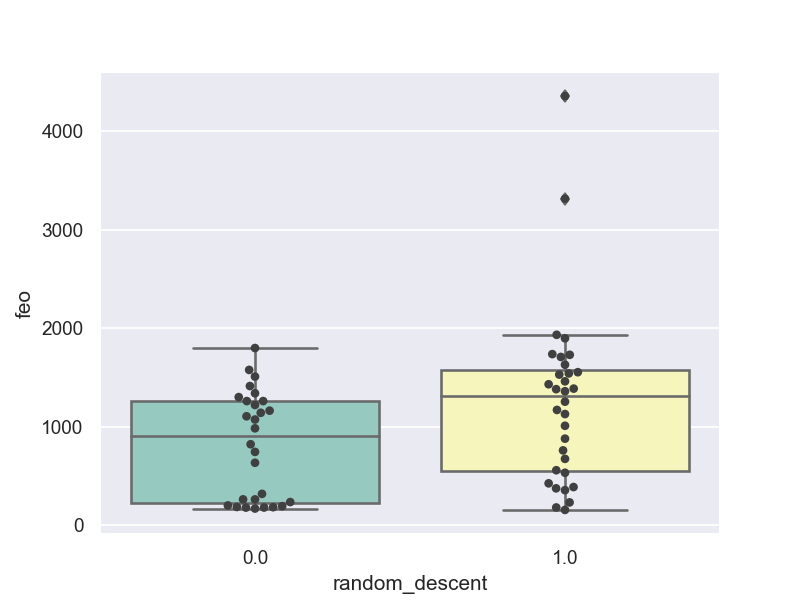

   random_descent          feo
0             0.0   810.387500
1             1.0  1250.392812


In [139]:
# how hyperparameters of first order heuristic influence feo?
data_sg = pd.read_csv(os.path.join('..', 'results', 
                        '{}_parameters.txt'.format(first_order_heur)), sep=",") 

sns.boxplot(x="random_descent", y="feo", data=data_sg, palette="Set3")
sns.swarmplot(x="random_descent", y="feo", data=data_sg, color=".25")
stats = pivot_table(df=data_sg, index=data_sg[["random_descent"]], values=data_sg[["feo"]])
print(stats)

Proměnná *random_descent* se nezdá být o tak výrazná. Provedeme lineární regresi, abychom zjistili, jak závisí feo na hyperparametrech heuristiky *SG*.

In [9]:
# Linear regression
X = data_sg.iloc[:,:-1]
y = data_sg.iloc[:,-1]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    feo   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     42.92
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           1.22e-14
Time:                        13:53:49   Log-Likelihood:                -479.64
No. Observations:                  60   AIC:                             965.3
Df Residuals:                      57   BIC:                             971.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
maxeval            1.8058      0.301      5.996      0.000       1.203       2.409
hmax             -47.2554     21.879     -2.160      0.035     -91.068      -3.443
random_descent   520.8926    186.994      2.786      0.007     146.444     895.342
==============================================================================
Omnibus:                       12.814   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.840
Skew:                           0.770   Prob(JB):                     0.000134
Kurtosis:                       5.183   Cond. No.                         924.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Všechny hyperparametry jsou na hladině 5 procent významné. Podle očekávání se zvyšujícím se počtem hmax klesá feo. Použití metody *random_descent* v *SG* zvyšuje feo. Je lepší evaluovat všechny sousedy a do dalšího kroku přejít do toho nejlepšího. Větší počet vyčíslení (*maxeval*) zvyšuje také feo. Při zvýšení *maxeval* nám feo mění dva efekty. První efekt nám feo snižuje. Při běhu jedné heuristiky máme větší šanci, že skončíme v f_star a celkově máme větší spolehlivost. Druhý efekt nám feo zvyšuje. Pokud se ale dostaneme do f_star za velký počet kroků, tak se nám zvýší střední počet kroků k nalezení řešení. Zřejmě převažuje druhý efekt nad tím prvním.

### Hledání nejlepších hyperparametrů pro heuristiku Fast Simmulated Annealing (10 minut)

In [10]:
# name of our first order heuristic
first_order_heur = "FSA"
# create files of our results, if they do not exist already
create_files(first_order_heur) # append new data into files, if they already exists

In [11]:
# we create second order objective function
second_order_of = TuneHyperparameters(first_order_heur, first_order_of, first_order_exp_time)
# run second order experiment
results_fsa = second_order_experiment(second_order_of, first_order_heur,
                    second_order_exp_num_runs, second_order_heur_maxeval,
                    second_order_heur_hmax, second_order_heur_random_descent)
save_object(results_fsa, globals())
print(results_fsa)

==============Start of second order experiment==============
PARAMETERS OF FSA: ['T0', 'maxeval', 'n0', 'alpha']
======0-th run of second order experiment with 10 evals======
Parameters_of_FSA: [67.563, 282.0, 0.664, 2.544], feo: 335.11
Parameters_of_FSA: [67.563, 282.0, 0.664, 2.851], feo: 355.48
Parameters_of_FSA: [0.0, 395.0, 2.336, 1.085], feo: 398.15
Parameters_of_FSA: [0.0, 395.0, 2.077, 1.085], feo: 315.94
Parameters_of_FSA: [0.208, 146.0, 2.485, 0.927], feo: 357.35
Parameters_of_FSA: [0.208, 146.0, 2.485, 0.957], feo: 350.58
Parameters_of_FSA: [0.0, 464.0, 0.53, 1.042], feo: 343.03
Parameters_of_FSA: [0.0, 464.0, 0.638, 1.042], feo: 318.61
Parameters_of_FSA: [0.0, 112.0, 2.412, 0.662], feo: 387.73
Parameters_of_FSA: [0.0, 112.0, 2.412, 0.662], feo: 381.05
======1-th run of second order experiment with 10 evals======
Parameters_of_FSA: [0.0, 605.0, 1.636, 2.377], feo: 326.09
Parameters_of_FSA: [0.0, 605.0, 1.899, 2.377], feo: 361.78
Parameters_of_FSA: [0.0, 406.0, 0.632, 3.817],

Jako významným faktorem se zdá být teplota, otestujeme v lineární regresi.

In [13]:
# how hyperparameters of first order heuristic influence feo?
data_fsa = read_data(first_order_heur, experiment="second")

# Linear regression
X = data_fsa.iloc[:,:-1]
y = data_fsa.iloc[:,-1]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    feo   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     202.9
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           2.22e-30
Time:                        14:11:27   Log-Likelihood:                -379.45
No. Observations:                  60   AIC:                             764.9
Df Residuals:                      57   BIC:                             771.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
T0             1.7974      0.144     12.488      0.000       1.509       2.086
n0           129.4074     19.072      6.785      0.000      91.217     167.598
alpha         87.7263     12.585      6.971      0.000      62.525     112.928
==============================================================================
Omnibus:                       27.272   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.366
Skew:                          -1.170   Prob(JB):                     3.93e-20
Kurtosis:                       8.502   Cond. No.                         153.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Všechny hyperparametry se ukazují být významné. Model dobře fituje data díky vysokému R kvadrátu.

### Hledání nejlepších hyperparametrů pro heuristiku Genetic Optimization (10 minut)

In [131]:
# name of our first order heuristic
first_order_heur = "GO"
# create files of our results, if they do not exist already
create_files(first_order_heur)

In [15]:
# we create second order objective function
second_order_of = TuneHyperparameters(first_order_heur, first_order_of, first_order_exp_time)
# run second order experiment
results_go = second_order_experiment(second_order_of, first_order_heur,
                    second_order_exp_num_runs, second_order_heur_maxeval,
                    second_order_heur_hmax, second_order_heur_random_descent)
save_object(results_go, globals())
print(results_go)

==============Start of second order experiment==============
PARAMETERS OF GO: ['maxeval', 'N', 'M', 'Tsel1', 'Tsel2']
======0-th run of second order experiment with 10 evals======
Parameters_of_GO: [523.0, 4.0, 13.0, 0.044, 0.601], feo: 286.77
Parameters_of_GO: [523.0, 4.0, 13.0, 0.044, 0.648], feo: 244.66
Parameters_of_GO: [754.0, 4.0, 15.0, 0.199, 0.866], feo: 278.71
Parameters_of_GO: [754.0, 4.0, 14.0, 0.199, 0.866], feo: 240.12
Parameters_of_GO: [450.0, 5.0, 11.0, 0.115, 0.52], feo: 250.68
Parameters_of_GO: [450.0, 5.0, 11.0, 0.141, 0.52], feo: 235.12
Parameters_of_GO: [414.0, 7.0, 12.0, 0.091, 1.086], feo: 233.29
Parameters_of_GO: [397.0, 7.0, 12.0, 0.091, 1.086], feo: 233.27
Parameters_of_GO: [884.0, 7.0, 16.0, 0.096, 1.097], feo: 266.88
Parameters_of_GO: [884.0, 7.0, 15.0, 0.096, 1.097], feo: 291.71
======1-th run of second order experiment with 10 evals======
Parameters_of_GO: [445.0, 5.0, 10.0, 0.057, 0.508], feo: 254.5
Parameters_of_GO: [445.0, 5.0, 10.0, 0.06, 0.508], feo: 

In [132]:
# how hyperparameters of first order heuristic influence feo?
data_go = read_data(first_order_heur, experiment="second")

# Linear regression
X = data_go.iloc[:,:-1]
y = data_go.iloc[:,-1]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    feo   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     547.2
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           1.43e-45
Time:                        20:49:42   Log-Likelihood:                -298.34
No. Observations:                  60   AIC:                             606.7
Df Residuals:                      55   BIC:                             617.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
maxeval        0.0597      0.022      2.726      0.009       0.016       0.104
N             17.9081      3.062      5.849      0.000      11.772      24.044
M              8.3575      1.876      4.455      0.000       4.598      12.117
Tsel1         20.6683    102.514      0.202      0.841    -184.775     226.111
Tsel2         23.6044     14.681      1.608      0.114      -5.817      53.026
==============================================================================
Omnibus:                        1.534   Durbin-Watson:                   1.201
Prob(Omnibus):                  0.465   Jarque-Bera (JB):                1.141
Skew:                           0.040   Prob(JB):                        0.565
Kurtosis:                       2.329   Cond. No.                     1.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Všechny hyperparametry až na obě selektivní teploty se zdají být významné. *Tsel1* a *Tsel2* vyhodíme a provedeme lineární regresi znova.

In [133]:
X = X.drop(columns=["Tsel1","Tsel2"])
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    feo   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     900.9
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           5.74e-48
Time:                        20:50:44   Log-Likelihood:                -299.75
No. Observations:                  60   AIC:                             605.5
Df Residuals:                      57   BIC:                             611.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
maxeval        0.0656      0.022      3.022      0.004       0.022       0.109
N             17.9219      3.012      5.950      0.000      11.891      23.953
M              9.9124      1.424      6.961      0.000       7.061      12.764
==============================================================================
Omnibus:                        0.414   Durbin-Watson:                   1.220
Prob(Omnibus):                  0.813   Jarque-Bera (JB):                0.571
Skew:                           0.151   Prob(JB):                        0.751
Kurtosis:                       2.629   Cond. No.                         330.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vysoký R kvadrát, lineární regrese dobře fituje data.

### Hledání nejlepších hyperparametrů pro heuristiku Differential Evolution (10 minut)

In [19]:
# name of our first order heuristic
first_order_heur = "DE"
# create files of our results, if they do not exist already
create_files(first_order_heur)

In [20]:
# we create second order objective function
second_order_of = TuneHyperparameters(first_order_heur, first_order_of, first_order_exp_time)
# run second order experiment
results_de = second_order_experiment(second_order_of, first_order_heur,
                    second_order_exp_num_runs, second_order_heur_maxeval,
                    second_order_heur_hmax, second_order_heur_random_descent)
save_object(results_de, globals())
print(results_de)

==============Start of second order experiment==============
PARAMETERS OF DE: ['maxeval', 'N', 'CR', 'F']
======0-th run of second order experiment with 10 evals======
Parameters_of_DE: [493.0, 4.0, 0.718, 1.567], feo: 274.06
Parameters_of_DE: [493.0, 4.0, 0.718, 1.635], feo: 280.07
Parameters_of_DE: [455.0, 12.0, 0.449, 1.895], feo: 406.0
Parameters_of_DE: [455.0, 12.0, 0.519, 1.895], feo: 363.63
Parameters_of_DE: [283.0, 18.0, 0.352, 1.585], feo: 535.06
Parameters_of_DE: [283.0, 18.0, 0.251, 1.585], feo: 513.22
Parameters_of_DE: [890.0, 11.0, 0.296, 0.198], feo: 390.74
Parameters_of_DE: [890.0, 11.0, 0.267, 0.198], feo: 392.26
Parameters_of_DE: [174.0, 8.0, 0.656, 0.837], feo: 385.6
Parameters_of_DE: [174.0, 8.0, 0.745, 0.837], feo: 323.62
======1-th run of second order experiment with 10 evals======
Parameters_of_DE: [787.0, 4.0, 0.13, 1.379], feo: 333.09
Parameters_of_DE: [787.0, 9.0, 0.13, 1.379], feo: 341.31
Parameters_of_DE: [155.0, 13.0, 0.152, 1.403], feo: 492.16
Parameters_o

In [25]:
# how hyperparameters of first order heuristic influence feo?
data_de = read_data(first_order_heur, experiment="second")

# Linear regression
X = data_de.iloc[:,:-1]
y = data_de.iloc[:,-1]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    feo   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     208.1
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           6.69e-33
Time:                        15:20:59   Log-Likelihood:                -357.26
No. Observations:                  60   AIC:                             722.5
Df Residuals:                      56   BIC:                             730.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
maxeval        0.0565      0.051      1.116      0.269      -0.045       0.158
N             28.7523      2.866     10.034      0.000      23.012      34.493
CR           135.3016     55.438      2.441      0.018      24.246     246.358
F             20.9765     21.863      0.959      0.341     -22.821      64.774
==============================================================================
Omnibus:                        3.543   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.622
Skew:                           0.386   Prob(JB):                        0.269
Kurtosis:                       3.673   Cond. No.                     2.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Do další regrese vyhodíme nevýznamné hyperparametry *maxeval* a *F*.

In [26]:
X = X.drop(columns=["maxeval", "F"])
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    feo   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     412.5
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           5.10e-35
Time:                        15:21:05   Log-Likelihood:                -358.49
No. Observations:                  60   AIC:                             721.0
Df Residuals:                      58   BIC:                             725.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
N             31.5958      2.190     14.426      0.000      27.212      35.980
CR           174.5372     49.188      3.548      0.001      76.077     272.998
==============================================================================
Omnibus:                        5.279   Durbin-Watson:                   1.138
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                4.437
Skew:                           0.499   Prob(JB):                        0.109
Kurtosis:                       3.882   Cond. No.                         37.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model velmi dobře fituje data (vysoký R kvadrát). Kritérium feo výrazně ovlivňují hyperparametry velikost populace a pravděpodobnost crossoveru.

## Vyhodnocení výsledků

In [130]:
print("----------------------------------------SG-------------------------------------------")
print(results_sg)
results = results_sg[["first_order_heur", "feo"]]
mean_and_variance(results_sg)
print("----------------------------------------FSA-------------------------------------------")
print(results_fsa)
results = results.append(results_fsa[["first_order_heur", "feo"]])
mean_and_variance(results_fsa)
print("----------------------------------------G0-------------------------------------------")
print(results_go)
results = results.append(results_go[["first_order_heur", "feo"]])
mean_and_variance(results_go)
print("----------------------------------------DE-------------------------------------------")
print(results_de)
results = results.append(results_de[["first_order_heur", "feo"]], ignore_index=True)
mean_and_variance(results_de)

----------------------------------------SG-------------------------------------------
  first_order_heur  maxeval  hmax  random_descent     feo
0               SG    177.0   5.0             0.0  183.90
1               SG    218.0  10.0             1.0  153.98
2               SG    158.0  18.0             0.0  178.20
3               SG    144.0   8.0             0.0  167.81
4               SG    288.0   4.0             0.0  260.69
5               SG    643.0   5.0             0.0  261.22
====Average of hyperparameters of top performing runs:====
                     maxeval   hmax  random_descent      feo
MEAN                  271.33   8.33            0.17   200.97
VARIANCE            35843.07  27.47            0.17  2262.81
----------------------------------------FSA-------------------------------------------
  first_order_heur            T0  maxeval     n0  alpha     feo
0              FSA  2.340000e-06    395.0  2.080   1.08  315.94
1              FSA  7.570000e-09    406.0  0.603   

<IPython.core.display.Javascript object>


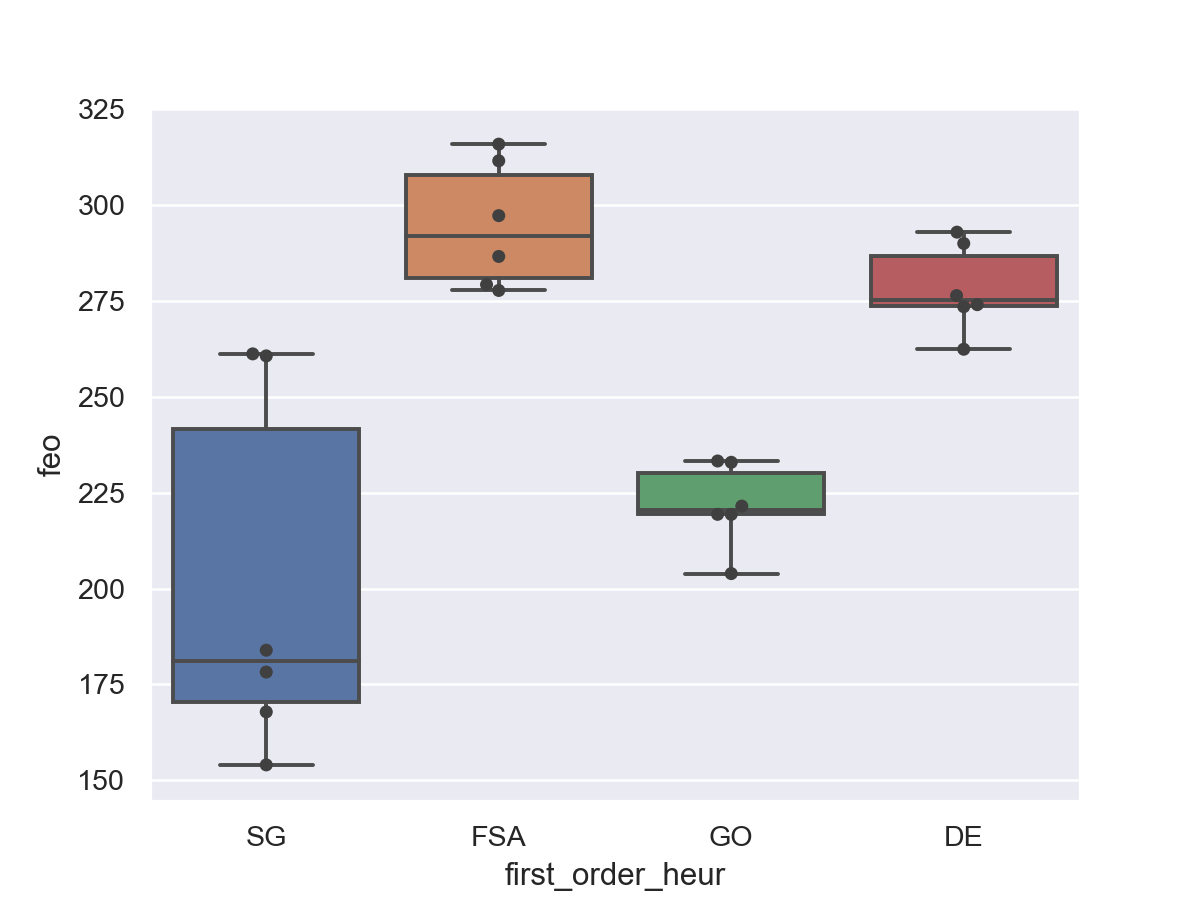

In [102]:
# I do not know how to run second plot without these import lines
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

sns.set()
sns.boxplot(x="first_order_heur", y="feo", data=results)
sns.swarmplot(x="first_order_heur", y="feo", data=results, color=".25")

In [72]:
stats = pivot_table(df=results, index=results[["first_order_heur"]], values=results[["feo"]])
print(stats)

  first_order_heur         feo
0               DE  278.241667
1              FSA  294.755000
2               GO  221.713333
3               SG  200.966667


Jako nejlepší heuristika na problém *TSPGrid(3,3)* se jeví *SG*, která vykazuje nejmenší feo. I grafická analýza tohle může potvrdit. Těsně za ní je heuristika *GO*. Heuristiky *FSA* a *DE* zaostávají.

### Diskuse
#### Shoot and Go
- U heuristiky *SG* se vyplatí udělat několik kroků (například podle nejlepšího výsledku až 10) a
až poté vystřelit znovu.
- Průměrně lepší se ukázalo volit *steepest_descent*, i když úplně nejlepší řešení používalo *random_descent*.
- Hyperparametr *maxeval* není dobré volit příliš vysoký. To platí pro všechny heuristiky.
- Pro volbu hyperparametrů můžeme zvolit dvě strategie. Buď vybereme ten nejlepší běh a budeme doufat, že nízké feo nebyla jen náhoda. Nebo vezmeme průměr z nejlepších běhů a budeme předpokládat, že funkce závislosti fea na hyperparametrech je dostatečně spojitá a předpokládáme tedy výsledné feo na úrovni průměru z těch nejlepších běhů. Tyto dvě strategie nazveme:
*Strategie pro nejlepší běh* a *Strategie pro průměr z nejlepších*.
- V závislosti na strategii doporučujeme vybrat tyto hyperparametry k heuristice *SG*:  
*SG nejlepší:* (maxeval = 218, hmax = 10, random_descent = True)  
*SG průměr nejlepších:* (maxeval = 271, hmax = 8, random_descent = False)
#### Fast Simulated Annealing
- U heuristiky *FSA* se jako velice významný parametr jeví počáteční teplota, kterou je u našeho problému vhodné volit v nízkých řádech, například až 1e-9. Nenechme se zde ale zmást vysokým průměrem, protože jedna hodnota této teploty o několik řádů vyšší nám průměr posunula k vyšším řádům. Proto ve strategii průměr nejlepších vezmeme tuto hodnotu ze strategie nejlepšího běhu.
- V závislosti na strategii doporučujeme vybrat tyto hyperparametry k heuristice *FSA*:  
*FSA nejlepší:* (T0 = 5.01e-8, maxeval = 293, n0 = 1.09, alpha = 1,77)  
*FSA průměr nejlepších:* (T0 = 5.01e-8, maxeval = 337, n0 = 1.03, alpha = 2,14)
#### Genetic Optimization
- U heuristiky *GO* jsme objevili nevýznamnost obou dvou selektivních teplot. Na jejich výběru u našeho problému tedy tolik nezáleží, ale přesto jejich hodnoty do doporučených strategií uvedeme.
- V závislosti na strategii doporučujeme vybrat tyto hyperparametry k heuristice *GO*:  
*GO nejlepší:* (maxeval = 163, N = 6, M = 14, Tsel1 = 0.16, Tsel2 = 0.48)  
*GO průměr nejlepších:* (maxeval = 256, N = 6, M = 13, Tsel1 = 0.1, Tsel2 = 0.71)
#### Differential Evolution
- U heuristiky *DE* jsme objevili dva nevýznamené hyperparametry: *maxeval* a *F*. Na jejich výběru u našeho problému tedy tolik nezáleží, ale přesto jejich hodnoty do doporučených strategií uvedeme.
- V závislosti na strategii doporučujeme vybrat tyto hyperparametry k heuristice *DE*:  
*DE nejlepší:* (maxeval = 282, N = 8, CR = 0.48, F = 1.35)  
*DE průměr nejlepších:* (maxeval = 400, N = 6, CR = 0.46, F = 1.04)

## Závěr
- Našli jsme pro objektivní funkci *TSPGrid(3,3)* nejlepší heuristiku a k ní příslušnou množinu
optimálních hyperparamterů vybraných z pevně dané mřížky. Touto heuristikou je *Shoot and Go* a příslušnými hyperparametry jsou:  
*hyperparametry_SG = (maxeval = 218, hmax = 10, random_descent = True)*.
- Náš sestrojený systém může hledat hyperparametry i pro libovolně větší mřížky problému obchodního cestujícího. Jen výpočtů bude buď méně při pevně zvoleném čase na experiment prvního řádu, nebo budou trvat déle. Při správné úpravě kódu může být tento systém použit i na hledání hyperparametrů heuristik pro jiné objektivní funkce.
- Pokud by chtěl uživatel dělat větší analýzu na datech z experimentů prvního a druhého řádu, má k dispozici funkce, které mu do vytvořených datových souborů připojí nová data.


